In [8]:
import matplotlib.pyplot as plt
import torch
import libs.angular_spectrum as AS
import libs.forward_model as fm
import numpy as np


### Circular Apecture

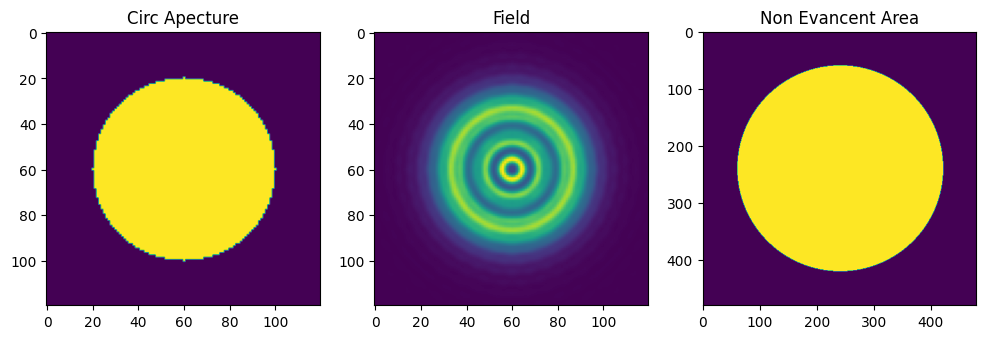

In [9]:
Nx, Ny = 120, 120
dx, dy, dz = .2,.2, 2 #um
lambda_ = .532 # um
mask_factor = 1
aNs = AS.d2nnASwWindow_layer( Nx, Ny, dx, dy, dz, lambda_, device= 'cpu', mask_factor = mask_factor)


R , cx, cy = Nx//3, Nx//2, Ny//2
circ_apecture = torch.zeros((Nx,Ny)).float()
X = torch.linspace(0, Nx-1, Nx)
Y = torch.linspace(0, Ny-1, Ny)

x,y = torch.meshgrid(X, Y)
distance = torch.sqrt((x - cx)**2 + (y - cy)**2 )
in_circ = distance <= R
circ_apecture[in_circ] = 1


aNs.find_transfer_function( 10*dz, mask_factor)

output_field = aNs.forward(circ_apecture.unsqueeze(0).float())
field = (output_field.abs()**2).detach()

fig, axes = plt.subplots(1,3, figsize=(12, 6))

axes[0].imshow(circ_apecture)
axes[0].set_title("Circ Apecture")
axes[1].imshow(field[0])
axes[1].set_title("Field")
axes[2].imshow(AS.non_evancent_area)
axes[2].set_title("Non Evancent Area")
plt.show()

### Verification

In [28]:
# Parameter Definition
NA = 1
Rindex= 1
lambda_= 532.0/ 1000 #um
dx,dy, dz= 2,2,.5 #um
Nx,Ny,Nz = 120,120,11

fm.init_parameters(NA_ = NA, Rindex_= Rindex, lambda_=lambda_, dx_=dx, dy_=dy, dz_=dz, Nx_=Nx, Ny_=Ny, Nz_=Nz)
aNs = AS.d2nnASwWindow_layer(Nx, Ny, dx, dy, dz, lambda_)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

verbose = False

Point Spread Function Initialization Failed...!!!


In [61]:
# DMD PATTERN INITIALIZATION
ep_dx, ep_dy = 48,48
fm.init_DMD(ep_dx_=ep_dx, ep_dy_=ep_dy)

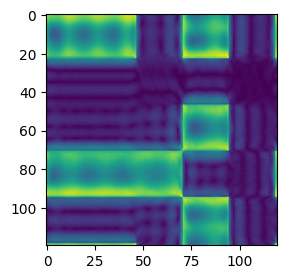

In [62]:
# Field Via Debye Theory
ht_3D = torch.zeros(1, Nz, Nx, Ny).float().to(device)
ht_3D[:, Nz // 2] = fm.ht_2D
debye_result = fm.conv_3D(fm.exPSF_3D, ht_3D).sum(dim=0).to('cpu')
plt.figure(figsize=(3,3))
plt.imshow(debye_result[5].abs())
plt.show()

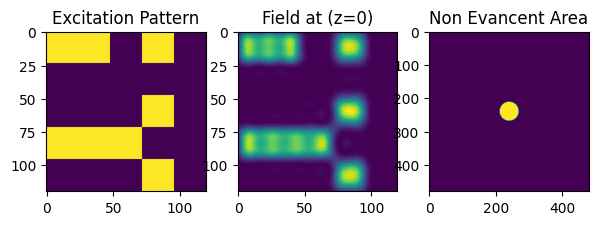

In [64]:
# Field Via Angular Spectrum Method
as_result = torch.zeros(Nz, Nx,Ny, dtype=torch.complex64)
mask_factor = 1/4000
for i in range(-Nz//2, Nz//2+1):
    aNs.find_transfer_function(dz*i,mask_factor_=mask_factor)
    output_field = aNs.forward(fm.ht_2D.unsqueeze(0))
    field = (output_field.abs()**2).detach()
    as_result[i+Nz//2] = output_field

    if (i==0):

        fig, axes = plt.subplots(1,3, figsize=(7, 3))
        axes[0].imshow(fm.ht_2D), axes[0].set_title("Excitation Pattern")
        axes[1].imshow(field[0]), axes[1].set_title(f"Field at (z={i})")
        axes[2].imshow(AS.non_evancent_area), axes[2].set_title("Non Evancent Area")
        plt.show()

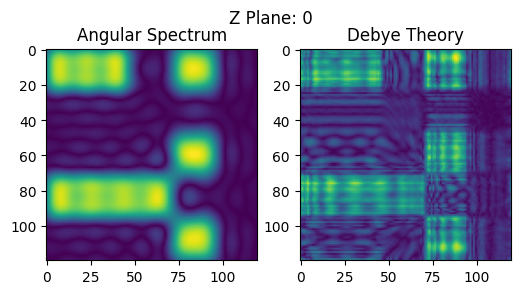

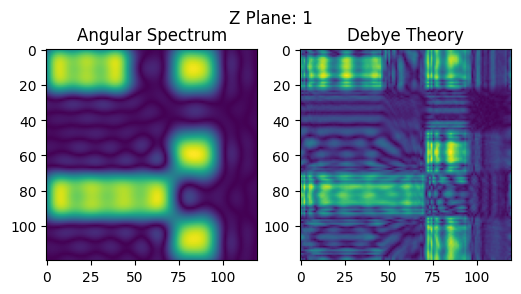

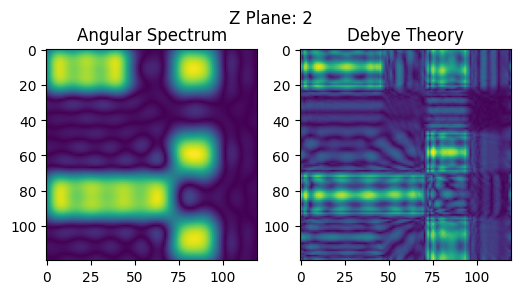

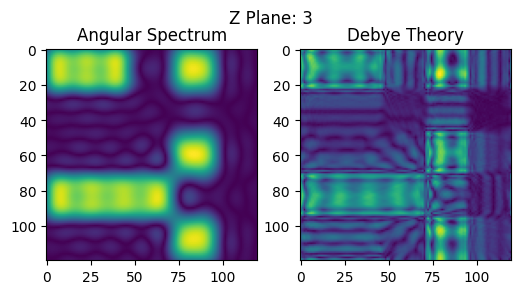

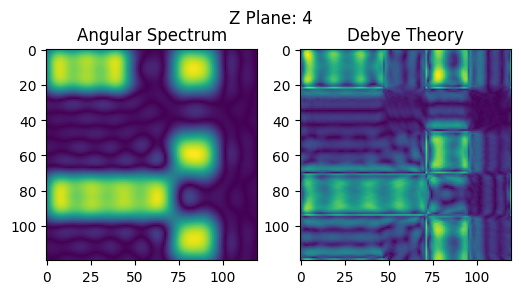

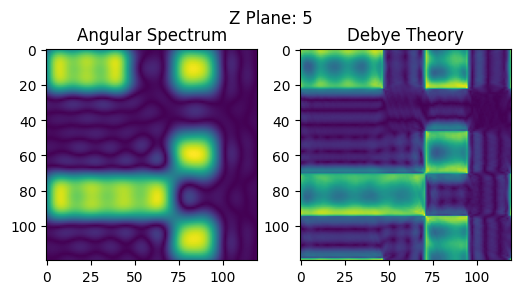

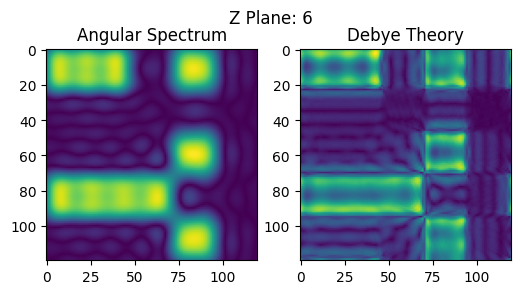

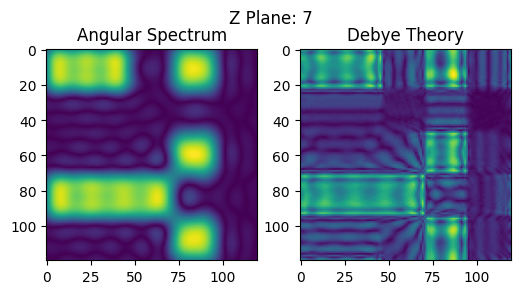

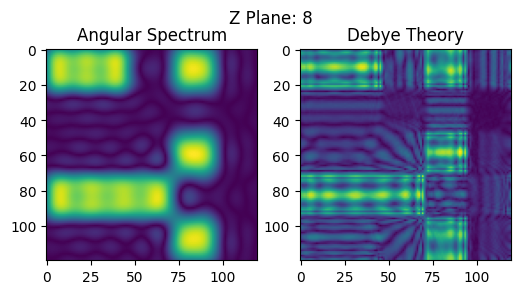

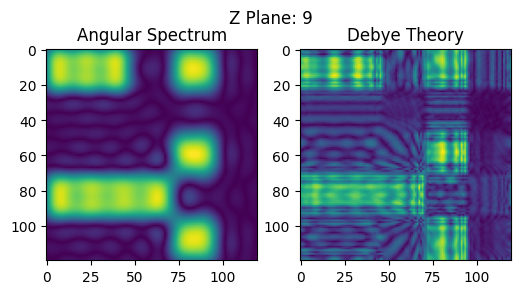

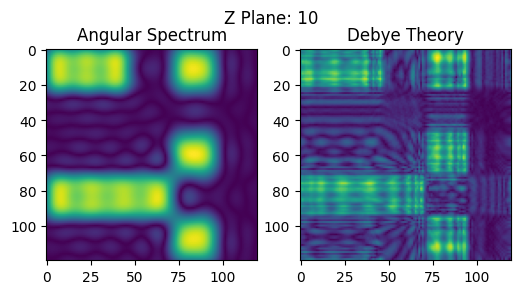

In [65]:
# Field Comparision
for i in range( Nz):
    fig, axes = plt.subplots(1,2, figsize=(6, 3))
    fig.suptitle(f"Z Plane: {i}")
    axes[0].imshow(as_result[i].abs().detach())
    axes[0].set_title("Angular Spectrum")
    axes[1].imshow(debye_result[i].abs())
    axes[1].set_title("Debye Theory")
    as_result[2]
    plt.show()